<a href="https://colab.research.google.com/github/jalonsomoya/FSCLogs/blob/master/ALS_Spark_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
path = './drive/My Drive/Colab Notebooks/'


/content


In [4]:
# Reading CSV of WS brand
pd_data_raw = pd.read_csv(path+'Ratings WS.zip', sep='\t', 
                            # nrows=100000,
                            encoding = 'UTF-8-SIG', engine = 'python', decimal=',')

print('Number of rating records: ' + str(len(pd_data_raw)))
print('Total of users: ' + str(pd_data_raw.USER_ID.nunique()))
print('Total of patterns: ' + str(pd_data_raw.PATRON.nunique()))

Number of rating records: 2157976
Total of users: 588532
Total of patterns: 3739


In [5]:
pd_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157976 entries, 0 to 2157975
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   USER_ID      object
 1   PATRON       int64 
 2   RATING       int64 
 3   PATRON_DESC  object
dtypes: int64(2), object(2)
memory usage: 65.9+ MB


Tras incluir los guest-users (a los usuarios no registrados se les da un id temporal), el campo USER_ID es alfanumérico.

In [6]:
#pd_ratings_WS['USER_ID'] = pd_ratings_WS['USER_ID'].str[-7:].astype(int)
# It isnt needed to cast this id as integer, we will do it later for ALS

For the ALS Model, it is needed to have an user_id consecutive and integer.

With the following code, setting first record as 0, and compare each following user increasing the integer new_id or not;
it takes too long to reasign the user identifier.


pd_ratings2 = pd_ratings_WS.copy()

pd_ratings2 = pd_ratings2.sort_values('USER_ID').reset_index(drop=True)
pd_ratings2['user_id_new'] = 0
cnt = 1
pd_ratings2.user_id_new[0] = cnt
for i in range(1,len(pd_ratings2)):
    if pd_ratings2.USER_ID[i] != pd_ratings2.USER_ID[i-1]:
        cnt += 1    
    pd_ratings2.user_id_new[i] = cnt
    if i%10000 == 0:
        print(i)
        

We are going to change the perspective, we'll take the users into a separate DF in order to .dropDuplicates() and add a column with the row_number.
With this new DF, we'll do a join to reasign de user_id


In [7]:
pd_user = pd.DataFrame(pd_data_raw["USER_ID"])
pd_user.drop_duplicates(inplace=True)
pd_user['rowid'] = pd_user.reset_index().index+1
pd_user

,USER_ID,rowid
0,01071253,1
1,01152861,2
2,01215284,3
4,01459570,4
5,01557274,5
...,...,...
2157958,9718-2602117,588528
2157964,9718-2621121,588529
2157965,9718-2622540,588530
2157966,9718-2623068,588531


In [8]:
pd_pat = pd.DataFrame(pd_data_raw["PATRON"])

pd_pat.drop_duplicates(inplace=True)
pd_pat['rowid2'] = pd_pat.reset_index().index+1
pd_pat

,PATRON,rowid2
0,4028341,1
1,4349342,2
2,3139093,3
3,3139204,4
4,4275969,5
...,...,...
2128821,8325111,3735
2136335,3546020,3736
2139011,4926447,3737
2144529,4027841,3738


In [9]:
pd_data_WS = pd.merge(pd_data_raw, pd_user, on='USER_ID',how='left')
pd_data_WS = pd.merge(pd_data_WS, pd_pat, on='PATRON',how='left')
pd_data_WS = pd_data_WS[['rowid','rowid2','RATING','PATRON_DESC']]
pd_data_WS.rename(columns={"rowid":"user"},inplace=True)
pd_data_WS.rename(columns={"rowid2":"patron"},inplace=True)
pd_data_WS.rename(columns={"PATRON_DESC":"desc"},inplace=True)
pd_data_WS.rename(columns={"RATING":"rating"},inplace=True)
pd_data_WS

,user,patron,rating,desc
0,1,1,3,FE1 LACE ST EMERALD
1,2,2,3,CT PAPALLONA TOP MULTIWAY
2,3,3,3,HW ROMANCE SET
3,3,4,3,KJ HK SUSHI PJ
4,4,5,3,ES ESPALDA MULTIESCOTES
...,...,...,...,...
2157971,588532,2273,5,HS MONDAY PJ
2157972,588532,2333,5,HS FRIDAY PJ
2157973,588532,2312,5,MM2 BLUE CENEFA LOUN
2157974,588532,793,5,WS CHUBBIES FOREVER RED


In [10]:
pd_items = pd_data_WS[['patron','desc','rating']] \
                .groupby(['patron','desc'])['rating'] \
                .mean().reset_index(name='rating') \
                .sort_values('rating', ascending =False)
pd_items

,patron,desc,rating
3738,3739,FLOCK SBD LICHT NUD,5.0
2438,2439,FL FLOCK ANTRA SB,5.0
2444,2445,FL FLOCK PINK BB,5.0
2443,2444,MM3-STITCH SLPRS,5.0
2442,2443,FE1 LACE BC EMERALD,5.0
...,...,...,...
3047,3048,HW-PE HANG VTY,3.0
3048,3049,MB-PE POUCH,3.0
3050,3051,SD-PE ALL BOOTS,3.0
181,182,BB SHINNY BLCK BODY,3.0


In [11]:
pd_ratings = pd_data_WS[['user','patron','rating']]
pd_ratings['rating'] = pd_ratings[['rating']].astype(float)
pd_ratings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user,patron,rating
0,1,1,3.0
1,2,2,3.0
2,3,3,3.0
3,3,4,3.0
4,4,5,3.0
...,...,...,...
2157971,588532,2273,5.0
2157972,588532,2333,5.0
2157973,588532,2312,5.0
2157974,588532,793,5.0


In [12]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.uvigo.es/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar -xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark pyspark==2.4.7

import os
import findspark
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 217.9MB 40kB/s 
     |████████████████████████████████| 204kB 39.2MB/s 


In [13]:
import pyspark

In [14]:
from pyspark.sql import SparkSession, functions as F
#from pyspark.sql.window import Window as W
#from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DecimalType

#from pyspark.sql.functions import substring
#from pyspark.sql.functions import monotonically_increasing_id
#spark = SparkSession.builder.getOrCreate()

In [15]:
#conf = SparkConf()
#spark = SparkSession.builder.getOrCreate()
#    .config(conf=conf) \
#    .appName('Spark_Builder') \

In [16]:
#Every field in spark dataframe is string ??

In [17]:
schema = StructType([StructField("user", IntegerType(), True),
                     StructField("patron", IntegerType(), True),
                     StructField("rating", DoubleType(), True)])

df_ratings = spark.createDataFrame(pd_ratings, schema=schema)
df_ratings.show(15)


+----+------+------+
|user|patron|rating|
+----+------+------+
|   1|     1|   3.0|
|   2|     2|   3.0|
|   3|     3|   3.0|
|   3|     4|   3.0|
|   4|     5|   3.0|
|   5|     6|   3.0|
|   6|     7|   3.0|
|   7|     8|   3.0|
|   8|     9|   3.0|
|   9|    10|   3.0|
|   9|    11|   3.0|
|  10|    12|   3.0|
|  11|    13|   3.0|
|  11|    11|   3.0|
|  12|    14|   3.0|
+----+------+------+
only showing top 15 rows



In [18]:
schema = StructType([StructField("patron", IntegerType(), True),
                     StructField("desc", StringType(), True),
                     StructField("rating", DoubleType(), True)])

df_items = spark.createDataFrame(pd_items, schema=schema)
df_items.show(5, False)

+------+----------------------------------+------+
|patron|desc                              |rating|
+------+----------------------------------+------+
|3739  |FLOCK SBD LICHT NUD               |5.0   |
|2439  |FL FLOCK ANTRA SB                 |5.0   |
|2445  |FL FLOCK PINK BB                  |5.0   |
|2444  |MM3-STITCH SLPRS                  |5.0   |
|2443  |FE1 LACE BC EMERALD               |5.0   |
+------+----------------------------------+------+
only showing top 5 rows



In [19]:
'''Configuración del modelo ALS en Spark'''

from pyspark.ml.recommendation import ALS

rec = ALS(maxIter=10, regParam=0.01, userCol='user',
           implicitPrefs=True,itemCol='patron',
          ratingCol='rating', nonnegative=True, coldStartStrategy="drop")


#Parámetros:

#* rank:        Number of latent factors in the model (defaults to 10).
#* maxIter:     Maximum number of iterations to run (defaults to 10).
#* regParam:    Regularization parameter in ALS (defaults to 1.0).
#* nonnegative: Use nonnegative constraints for least squares (defaults to false).


### Entrenamiento

In [20]:
rec_model = rec.fit(df_ratings)

### Transformación

In [ ]:
df_predicted_ratings = rec_model.transform(df_ratings)
df_predicted_ratings.show(5)

Vamos a buscar un producto en la web

In [22]:

item_example = pd_pat[pd_pat.rowid2==496]
item_example 

,PATRON,rowid2
628,4331540,496


In [23]:
item_example = pd_data_raw[pd_data_raw.PATRON==4331540]
item_example

,USER_ID,PATRON,RATING,PATRON_DESC
628,04687359,4331540,5,REG.CONTORNO G (AC853)2*3
3511,04703236,4331540,5,REG.CONTORNO G (AC853)2*3
8857,04733320,4331540,5,REG.CONTORNO G (AC853)2*3
15080,04773160,4331540,5,REG.CONTORNO G (AC853)2*3
19472,04802016,4331540,5,REG.CONTORNO G (AC853)2*3
...,...,...,...,...
2147139,9644-2334314,4331540,5,REG.CONTORNO G (AC853)2*3
2149054,9644-2396144,4331540,5,REG.CONTORNO G (AC853)2*3
2152258,9644-2490271,4331540,5,REG.CONTORNO G (AC853)2*3
2153271,9644-2510903,4331540,5,REG.CONTORNO G (AC853)2*3



https://womensecret.com/es/es/sujetadores/accesorios-sujetador/reguladores-de-contorno-grandes/4331540.html


In [24]:
'''Escogemos un usuario y rankeamos las predicciones'''

user = 500

df_predicted_ratings.filter(F.col('user') == user)\
                 .orderBy(F.col('patron')).show(5)  

df_predicted_ratings.filter(F.col('user') == user)\
                 .orderBy(F.col('prediction'), ascending=False).show(5)

+----+------+------+------------+
|user|patron|rating|  prediction|
+----+------+------+------------+
| 500|   515|   5.0| 0.007245638|
| 500|   524|   5.0|0.0025098284|
+----+------+------+------------+

+----+------+------+------------+
|user|patron|rating|  prediction|
+----+------+------+------------+
| 500|   515|   5.0| 0.007245638|
| 500|   524|   5.0|0.0025098284|
+----+------+------+------------+



In [25]:
df_predicted_ratings.filter(F.col('user')==500).show()

+----+------+------+------------+
|user|patron|rating|  prediction|
+----+------+------+------------+
| 500|   524|   5.0|0.0025098284|
| 500|   515|   5.0| 0.007245638|
+----+------+------+------------+



### Evaluación

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

rmse = evaluator.evaluate(df_predicted_ratings)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 4.785450890308498


In [27]:
pd_predicted_ratings = df_predicted_ratings.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
pd_predicted_ratings.head()

,user,patron,rating,prediction,dif
0,280056,148,3.0,7.922431e-08,3.000000
1,140030,148,3.0,3.120475e-06,2.999997
2,280156,148,3.0,2.650066e-10,3.000000
3,97,148,3.0,2.650066e-10,3.000000
4,324400,463,5.0,2.062430e-02,4.979376


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


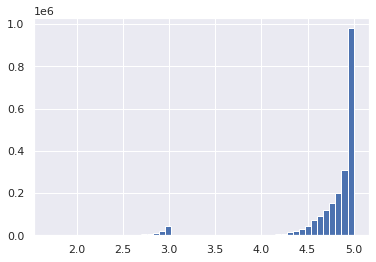

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.hist(pd_predicted_ratings.dif, bins=50)
plt.show()

In [29]:
%%time
# Las 5 mejores peliculas para todos los usuarios
userRecs = rec_model.recommendForAllUsers(10)

# Cambio de usuario
user = 30500

# Filtramos para nuestro usuario concreto
userRecs.filter(F.col('user')==user).show(1,False)


+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user |recommendations                                                                                                                                                                                 |
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|30500|[[603, 0.11059806], [534, 0.10685304], [194, 0.10305053], [612, 0.10243335], [994, 0.09458501], [732, 0.08386179], [381, 0.0817758], [470, 0.080793366], [1106, 0.078627706], [528, 0.07830925]]|
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Root-mean-square error = 1.1961895363305002


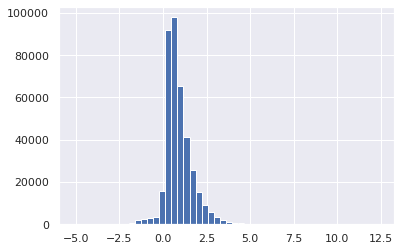

+----+---------------------------------------------------------------------------------------+
|user|recommendations                                                                        |
+----+---------------------------------------------------------------------------------------+
|3   |[[2964, 3.0169885], [3, 2.9310188], [4, 2.9310188], [3510, 2.6271029], [3533, 2.59558]]|
+----+---------------------------------------------------------------------------------------+

CPU times: user 2.38 s, sys: 72.9 ms, total: 2.46 s
Wall time: 3min 38s


In [30]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=5, regParam=0.11, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

userRecs = model.recommendForAllUsers(5)
userRecs.filter(F.col('user')==3).show(1,False)

In [31]:
%%time
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = df_ratings.randomSplit([80.0, 20.0])
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

paramGrid = ParamGridBuilder()\
                .addGrid(als.rank, [5, 10])\
                .addGrid(als.maxIter, [3, 5, 7, 11])\
                .addGrid(als.regParam, [0.01, 0.03, 0.05, 0.07, 0.11]).build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)
bestModel = cvModel.bestModel

print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))

The root mean squared error for our model is: 1.1075121466334175
CPU times: user 3.39 s, sys: 966 ms, total: 4.36 s
Wall time: 11min 36s


In [32]:
cvModel.bestModel.extractParamMap()

{Param(parent='ALS_2e629f075101', name='coldStartStrategy', doc='strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: nan,drop.'): 'drop',
 Param(parent='ALS_2e629f075101', name='itemCol', doc='column name for item ids. Ids must be within the integer value range.'): 'patron',
 Param(parent='ALS_2e629f075101', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='ALS_2e629f075101', name='userCol', doc='column name for user ids. Ids must be within the integer value range.'): 'user'}

In [74]:
bestModel._java_obj.getRegParam()

Py4JError: ignored

In [46]:
cvModel.bestModel.params

[Param(parent='ALS_2e629f075101', name='coldStartStrategy', doc='strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: nan,drop.'),
 Param(parent='ALS_2e629f075101', name='itemCol', doc='column name for item ids. Ids must be within the integer value range.'),
 Param(parent='ALS_2e629f075101', name='predictionCol', doc='prediction column name'),
 Param(parent='ALS_2e629f075101', name='userCol', doc='column name for user ids. Ids must be within the integer value range.')]

In [40]:
cvModel.bestModel.getParam('itemCol')

Param(parent='ALS_2e629f075101', name='itemCol', doc='column name for item ids. Ids must be within the integer value range.')

## TUNING A MANUBRIO

Root-mean-square error = 1.1964427722979287


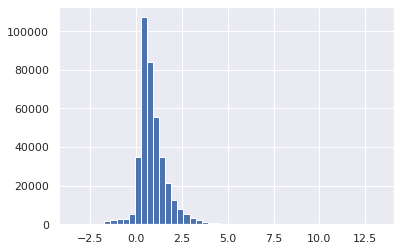

CPU times: user 3.28 s, sys: 114 ms, total: 3.39 s
Wall time: 1min 8s


In [47]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=5, regParam=0.11, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

Root-mean-square error = 4.47605898957128


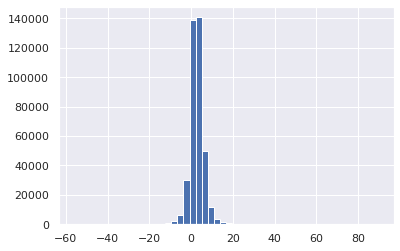

CPU times: user 2.72 s, sys: 75.6 ms, total: 2.8 s
Wall time: 1min 5s


In [48]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

Root-mean-square error = 2.931939706263076


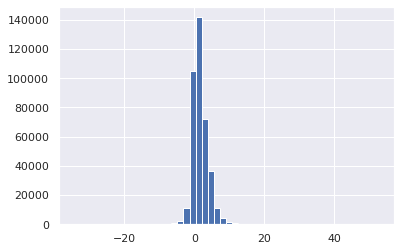

CPU times: user 2.77 s, sys: 87.6 ms, total: 2.85 s
Wall time: 1min 17s


In [49]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=10, regParam=0.01, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

Root-mean-square error = 0.5234690627569621


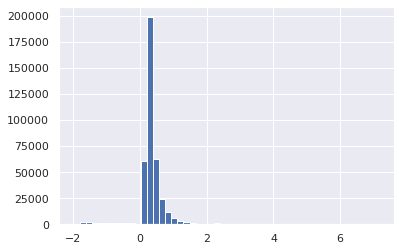

CPU times: user 2.8 s, sys: 100 ms, total: 2.9 s
Wall time: 1min 22s


In [50]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=10, regParam=0.11, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

Root-mean-square error = 1.0719304489969876


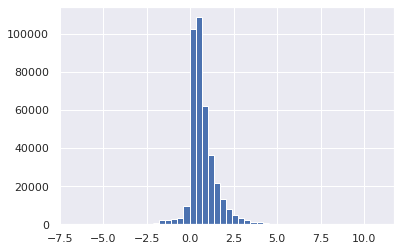

CPU times: user 3.23 s, sys: 105 ms, total: 3.34 s
Wall time: 1min 24s


In [51]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=10, regParam=0.05, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

Root-mean-square error = 2.132330477020464


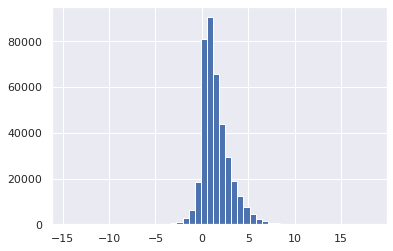

CPU times: user 2.95 s, sys: 93.9 ms, total: 3.05 s
Wall time: 1min 9s


In [52]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=5, regParam=0.05, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

In [59]:
 # Loplop

 maxiter = (10)
 regparam = (0.11)
 maxiter


10

In [61]:

(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter = 10, regParam = 0.2, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

maxIter: 10
regparam: 0.11
Root-mean-square error = 0.4548116690024885


In [62]:
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter = 10, regParam = 1, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))

#* rank:        Number of latent factors in the model (defaults to 10).
#* maxIter:     Maximum number of iterations to run (defaults to 10).
#* regParam:    Regularization parameter in ALS (defaults to 1.0).
#* nonnegative: Use nonnegative constraints for least squares (defaults to false).


maxIter: 10
regparam: 0.11
Root-mean-square error = 1.0616557141346505


In [67]:
%%time
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 10
regparam = 0.2
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.2
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 10
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

maxIter: 10
regparam: 0.2
Root-mean-square error = 0.4536814977194677
---------------------------
maxIter: 15
regparam: 0.2
Root-mean-square error = 0.4338657937367147
---------------------------
maxIter: 10
regparam: 0.15
Root-mean-square error = 0.4634466397590094
---------------------------
maxIter: 15
regparam: 0.15
Root-mean-square error = 0.42562361635224844
---------------------------
CPU times: user 700 ms, sys: 214 ms, total: 915 ms
Wall time: 4min 11s


In [68]:
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.2
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

maxIter: 15
regparam: 0.2
Root-mean-square error = 0.43005082956632007
---------------------------
maxIter: 15
regparam: 0.15
Root-mean-square error = 0.42459314524283487


In [69]:
print("---------------------------")
(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.18
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.165
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")


(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 15
regparam = 0.185
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")


(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 18
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")


(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 20
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

---------------------------
maxIter: 15
regparam: 0.18
Root-mean-square error = 0.4267298184291346
---------------------------
maxIter: 15
regparam: 0.165
Root-mean-square error = 0.42405806957517195
---------------------------
maxIter: 15
regparam: 0.185
Root-mean-square error = 0.4273286763024749
---------------------------
maxIter: 18
regparam: 0.15
Root-mean-square error = 0.41893237427984764
---------------------------
maxIter: 20
regparam: 0.15
Root-mean-square error = 0.4131788905707953
---------------------------


In [77]:
print("---------------------------")


(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 5
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 25
regparam = 0.15
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

(training, test) = df_ratings.randomSplit([0.8, 0.2])
# Entrenamos con training set
maxiter = 20
regparam = 0.135
als = ALS(maxIter = maxiter, regParam = regparam, userCol="user", itemCol="patron", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("maxIter: " + str(maxiter))
print("regparam: " + str(regparam))
print("Root-mean-square error = " + str(rmse))
print("---------------------------")

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42971)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


---------------------------


Py4JNetworkError: ignored


BUSCAR PATRONES QUE SIGAN CON STOCK EN WEB PARA MOSTRAR EL LINK A LA PÁGINA WEB

VOLVER A CRUZAR LOS RESULTADOS CON PDPAT, INCLUIR EXTERNAMENTE OTRO DF CON UNA DESCRIPCIÓN MEJOR DEL PATRÓN


EMPEZAR CON SCORES

PENSAR EN ESTRUCTURACIÓN DE TFM Y PRESENTACIÓN
